In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Charger les données
df = pd.read_csv('../datasets/Energy.csv', index_col=0, parse_dates=True)

# Calcul des rendements logarithmiques
returns = np.log(df / df.shift(1)).dropna()

# Calcul des paramètres pour l'optimisation
mu = returns.mean() * 252  # Annualisation (252 jours boursiers)
Sigma = returns.cov() * 252  # Annualisation de la matrice de covariance
num_assets = len(mu)

# Méthode de résolution par scalarisation pour générer la frontière efficiente

$ \(min_w \left{ \lambda \cdot (w^T \Sigma w) - (1 - \lambda) \cdot (w^T \mu) \right}) $

In [4]:
# Définir la fonction objectif pour la scalarisation
def objective(w, lambda_param):
    portfolio_return = np.dot(w, mu)
    portfolio_variance = np.dot(w, np.dot(Sigma, w))
    return lambda_param * portfolio_variance - (1 - lambda_param) * portfolio_return

# Contraintes
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})  # Sum w_i = 1
bounds = tuple((0, 1) for _ in range(num_assets))  # w_i entre 0 et 1

# Point de départ (portefeuille équipondéré)
initial_guess = np.array(num_assets * [1. / num_assets])

# Générer la frontière efficiente en variant lambda
lambdas = np.linspace(0, 1, 50)  # 100 points entre 0 et 1
frontier_returns = []
frontier_volatilities = []
frontier_weights = []

for lambda_param in lambdas:
    result = minimize(objective, initial_guess, args=(lambda_param,), method='SLSQP', bounds=bounds, constraints=constraints)
    if result.success:
        w_opt = result.x
        frontier_returns.append(np.dot(w_opt, mu))
        frontier_volatilities.append(np.sqrt(np.dot(w_opt, np.dot(Sigma, w_opt))))
        frontier_weights.append(w_opt)
    else:
        print(f"Optimization failed for lambda={lambda_param}")

# Convertir en arrays numpy pour faciliter l'analyse
frontier_returns = np.array(frontier_returns)
frontier_volatilities = np.array(frontier_volatilities)

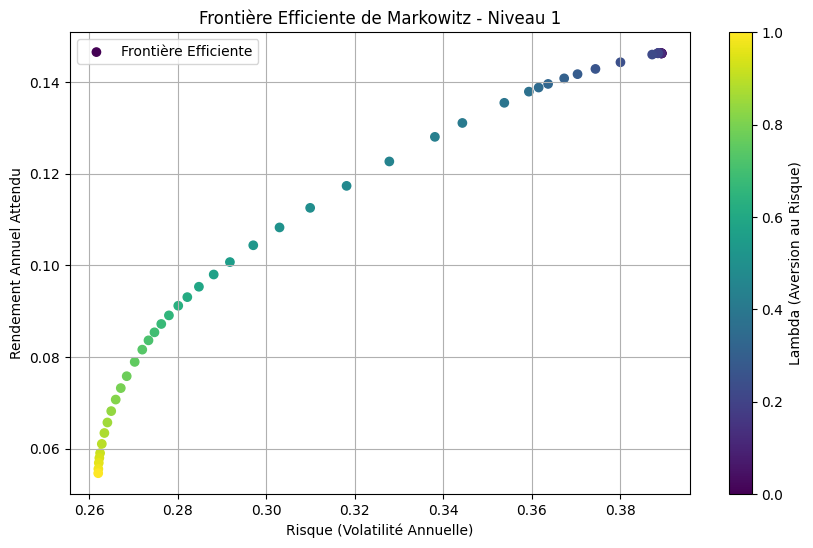

In [5]:
# Tracer la frontière efficiente
plt.figure(figsize=(10, 6))
plt.scatter(frontier_volatilities, frontier_returns, c=lambdas, cmap='viridis', label='Frontière Efficiente')
plt.colorbar(label='Lambda (Aversion au Risque)')
plt.xlabel('Risque (Volatilité Annuelle)')
plt.ylabel('Rendement Annuel Attendu')
plt.title('Frontière Efficiente de Markowitz - Niveau 1')
plt.grid(True)
plt.legend()
plt.show()